In [2]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample
import shap
from matplotlib import pyplot as plt
from sklearn.utils import resample, shuffle
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [3]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    X, display_data, feature_names, n_features, n_samples, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)
with open('subsets.pickle', 'rb') as f:
    is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, proba_diff_a_pos, proba_diff_b_pos, proba_diff, log_odds_diff_a_pos, log_odds_diff_b_pos, log_odds_diff = pickle.load(f)
    
# Sample
X, display_data, \
    pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b, \
    is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, proba_diff_a_pos, proba_diff_b_pos, proba_diff, log_odds_diff_a_pos, log_odds_diff_b_pos, log_odds_diff = \
    shuffle(X, display_data, \
            pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b, \
            is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, proba_diff_a_pos, proba_diff_b_pos, proba_diff, log_odds_diff_a_pos, log_odds_diff_b_pos, log_odds_diff, \
            random_state=42, n_samples=500)
n_samples = X.shape[0]
indices = np.array(range(n_samples))

In [4]:
try:
    with open('shapvalues.proba.pickle', 'rb') as f:
        shap_values_diff, shap_values_diff_a_pos, shap_values_diff_b_pos, overall_importance, feature_order, shap_values_diff_a_vs_b_pos = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


## Generate Explanations

Now we define the difference functions to be explained:

In [4]:
merge_proba_diff_c1_pos = lambda p1, p2: p1[:, 1] * p2[:, 0]
predict_proba_diff_a_pos = lambda X: merge_proba_diff_c1_pos(clf_a.predict_proba(X), clf_b.predict_proba(X))
predict_proba_diff_b_pos = lambda X: merge_proba_diff_c1_pos(clf_b.predict_proba(X), clf_a.predict_proba(X))

In [5]:
merge_proba_diff = lambda p1, p2: merge_proba_diff_c1_pos(p1, p2) + merge_proba_diff_c1_pos(p2, p1)
predict_proba_diff = lambda X: merge_proba_diff(clf_a.predict_proba(X), clf_b.predict_proba(X))

And now we calculate SHAP values for each merge function:

In [6]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=100)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    shap_values.display_data = display_data
    return shap_values

shap_values_diff_a_pos = explain(predict_proba_diff_a_pos)
shap_values_diff_b_pos = explain(predict_proba_diff_b_pos)

shap_values_diff = shap_values_diff_a_pos + shap_values_diff_b_pos
shap_values_diff.data = shap_values_diff_a_pos.data
shap_values_diff.display_data = shap_values_diff_a_pos.display_data

overall_importance = shap_values_diff.abs.mean(axis=0)
feature_order = np.flip(overall_importance.values.argsort())

shap_values_diff_a_vs_b_pos = shap_values_diff_b_pos - shap_values_diff_a_pos
shap_values_diff_a_vs_b_pos.data = shap_values_diff_a_pos.data
shap_values_diff_a_vs_b_pos.display_data = shap_values_diff_a_pos.display_data

with open(f'shapvalues.proba.pickle', 'wb') as f:
    pickle.dump((shap_values_diff, shap_values_diff_a_pos, shap_values_diff_b_pos, overall_importance, feature_order, shap_values_diff_a_vs_b_pos), f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 501it [00:35, 11.09it/s]                         
Permutation explainer: 501it [00:38,  9.34it/s]                         


CPU times: user 2min 38s, sys: 42.5 s, total: 3min 20s
Wall time: 1min 14s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

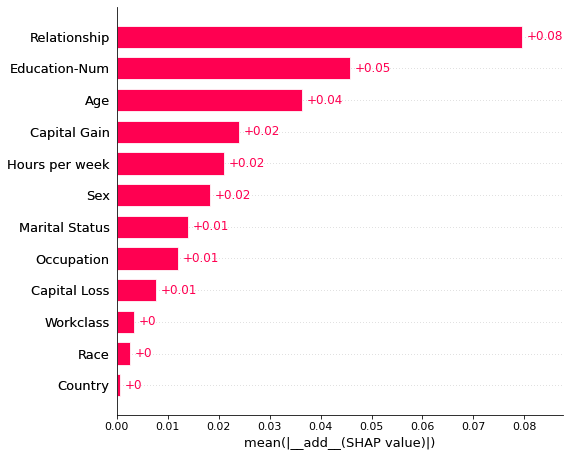

In [7]:
shap.plots.bar(overall_importance, max_display=n_features)

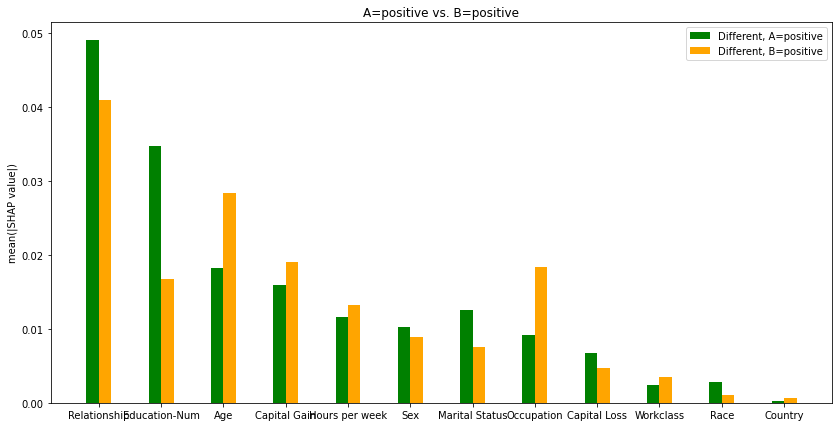

In [8]:
x = np.arange(n_features)
width = 0.2
fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, shap_values_diff_a_pos.abs.mean(0)[feature_order].values, width, label='Different, A=positive', color='green')
rects2 = ax.bar(x + width/2, shap_values_diff_b_pos.abs.mean(0)[feature_order].values, width, label='Different, B=positive', color='orange')
ax.set_ylabel('mean(|SHAP value|)')
ax.set_title('A=positive vs. B=positive')
ax.set_xticks(x)
ax.set_xticklabels(feature_names[feature_order])
ax.legend()
plt.show()

### SHAP Value Distribution

Next, we will try to understand the importances using the whole distribution of values, not only the aggregated mean.

TODO: build own plots, where all sets of instances are in one plot, with different colors per set and a color range from low to high feature value as well

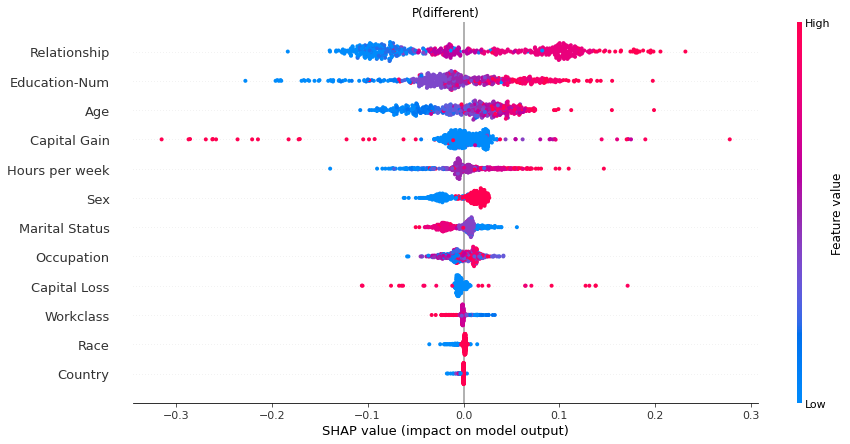

In [9]:
plot.shap_beeswarm(shap_values_diff, 'P(different)', order=feature_order, max_display=n_features)

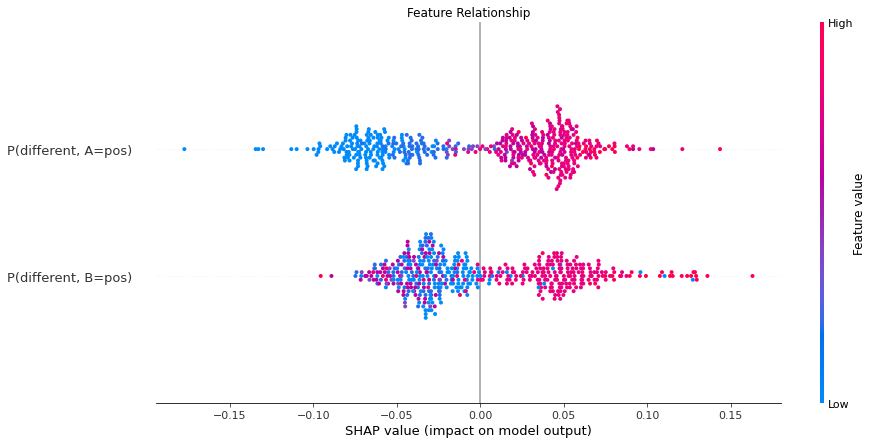

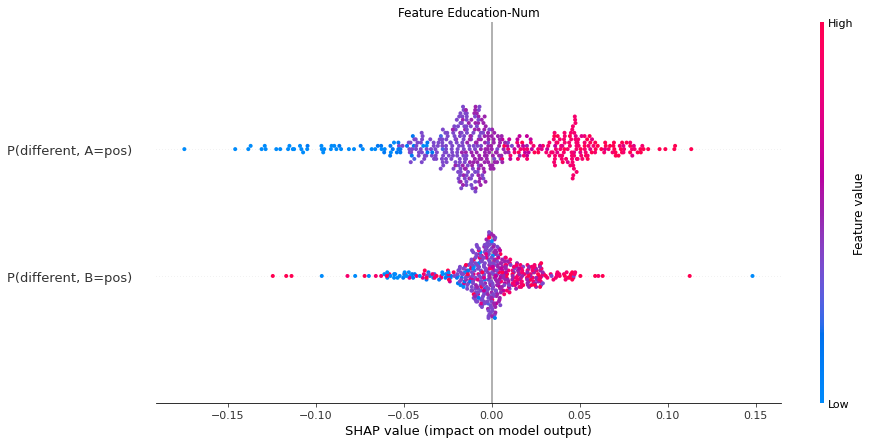

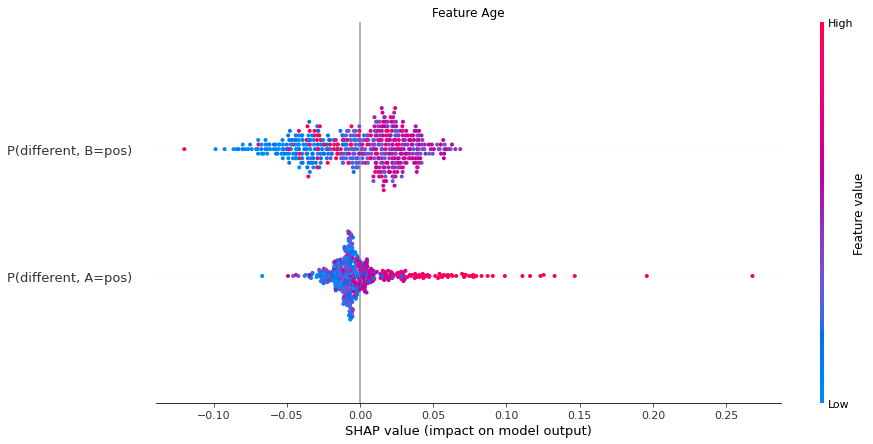

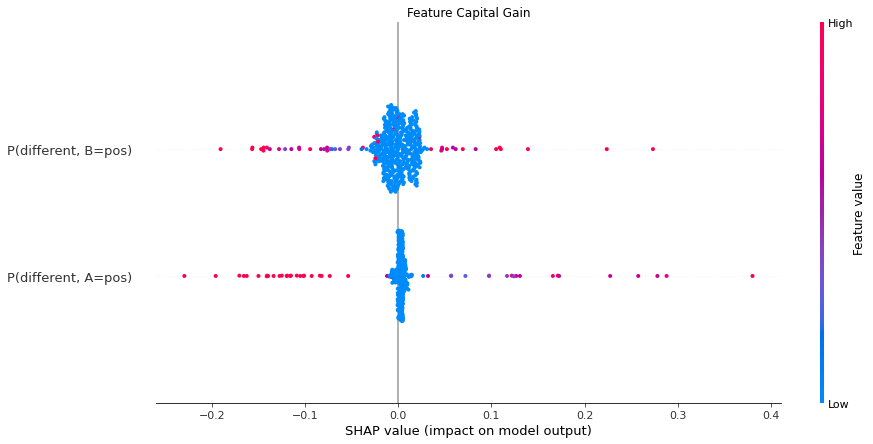

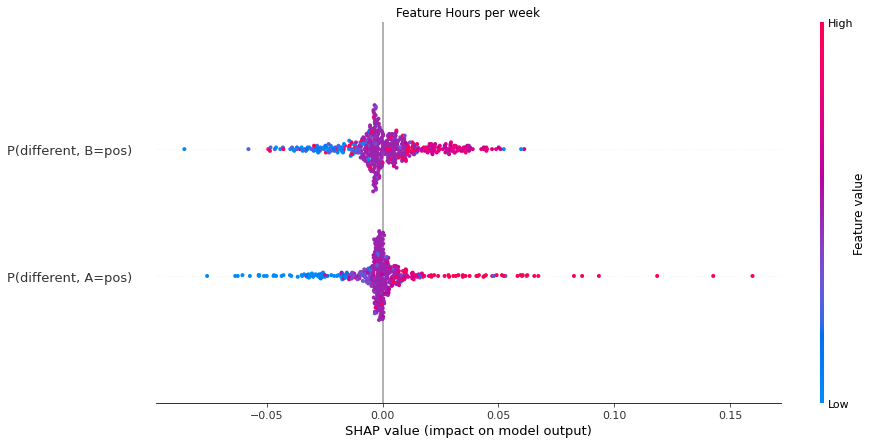

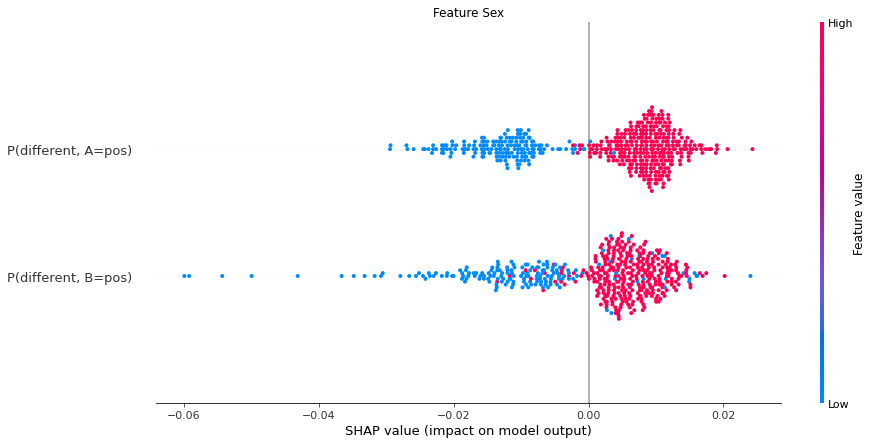

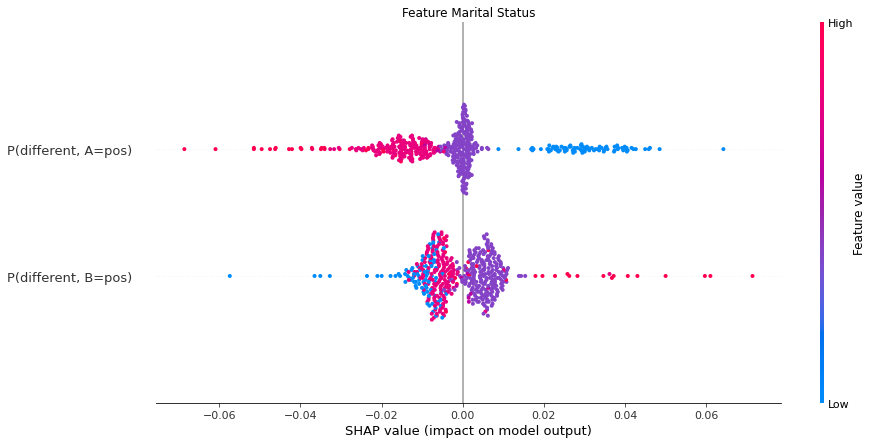

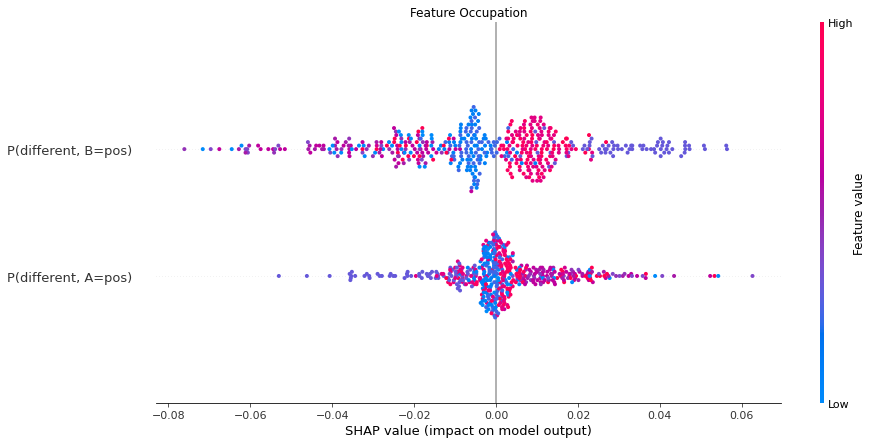

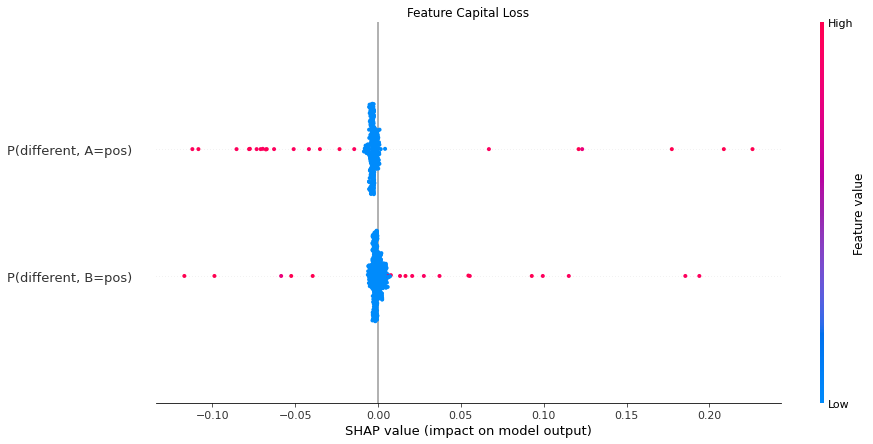

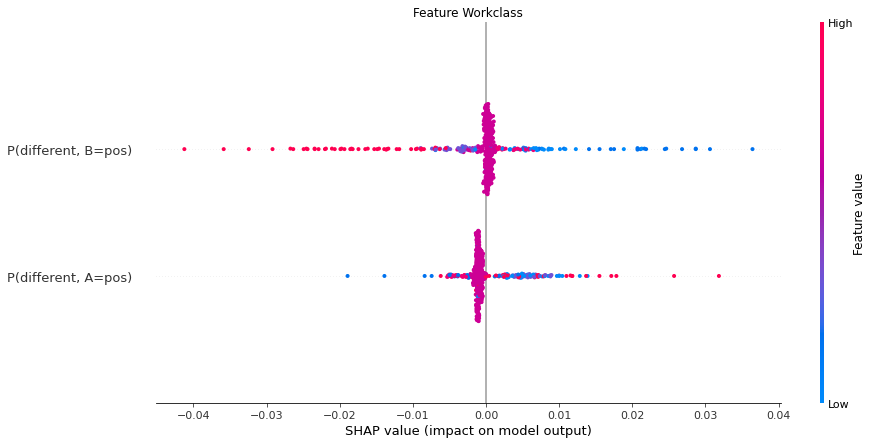

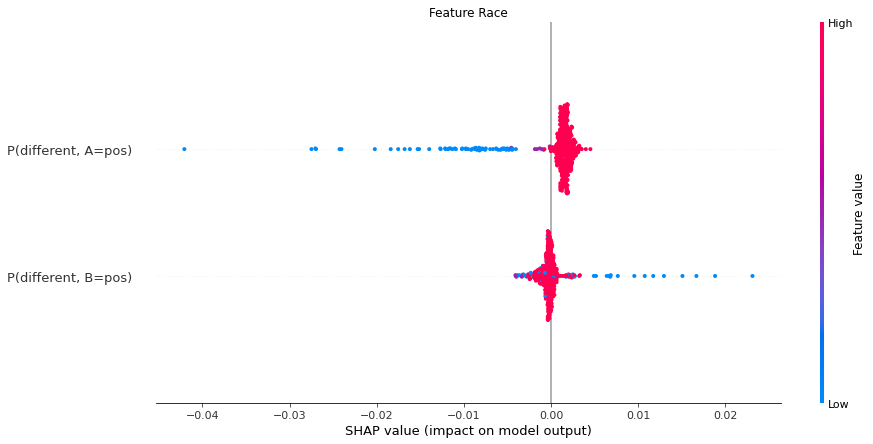

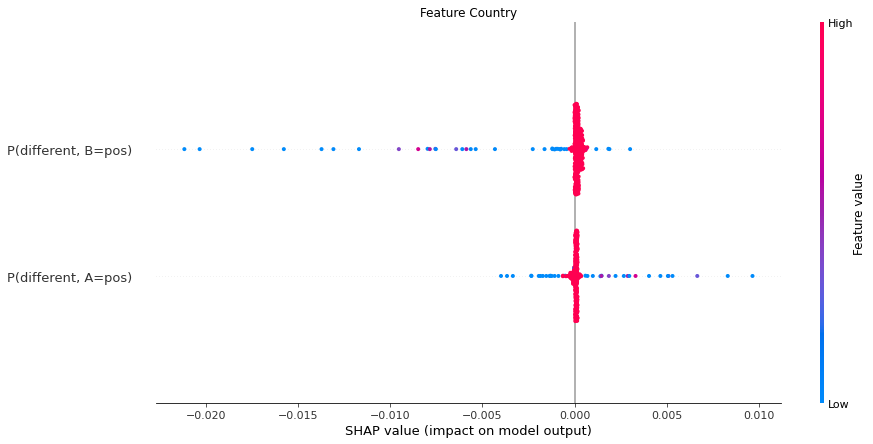

In [10]:
for feature in feature_names[feature_order]:
    a_feature = shap_values_diff_a_pos[:, feature]
    b_feature = shap_values_diff_b_pos[:, feature]
    values = np.array([a_feature.values, b_feature.values]).T
    data = np.array([a_feature.data, b_feature.data]).T
    display_data = np.array([a_feature.display_data, b_feature.display_data]).T
    explanation = shap.Explanation(values, data=data, display_data=display_data, feature_names=['P(different, A=pos)', 'P(different, B=pos)'])
    plot.shap_beeswarm(explanation, 'Feature ' + feature)

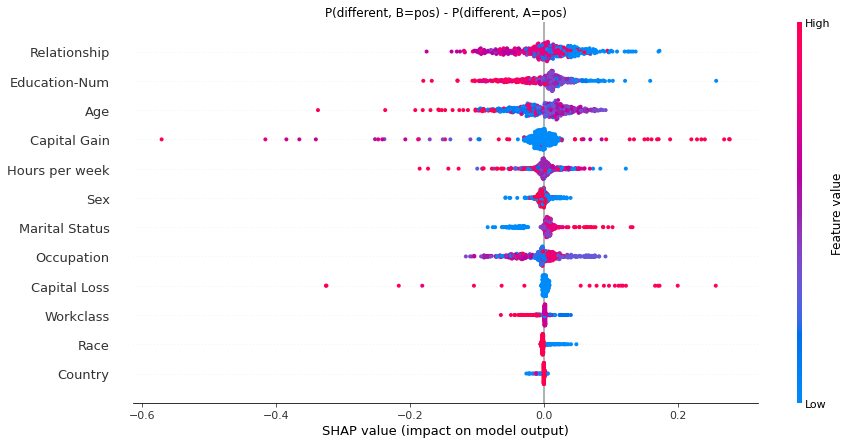

In [11]:
plot.shap_beeswarm(shap_values_diff_a_vs_b_pos, 'P(different, B=pos) - P(different, A=pos)', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


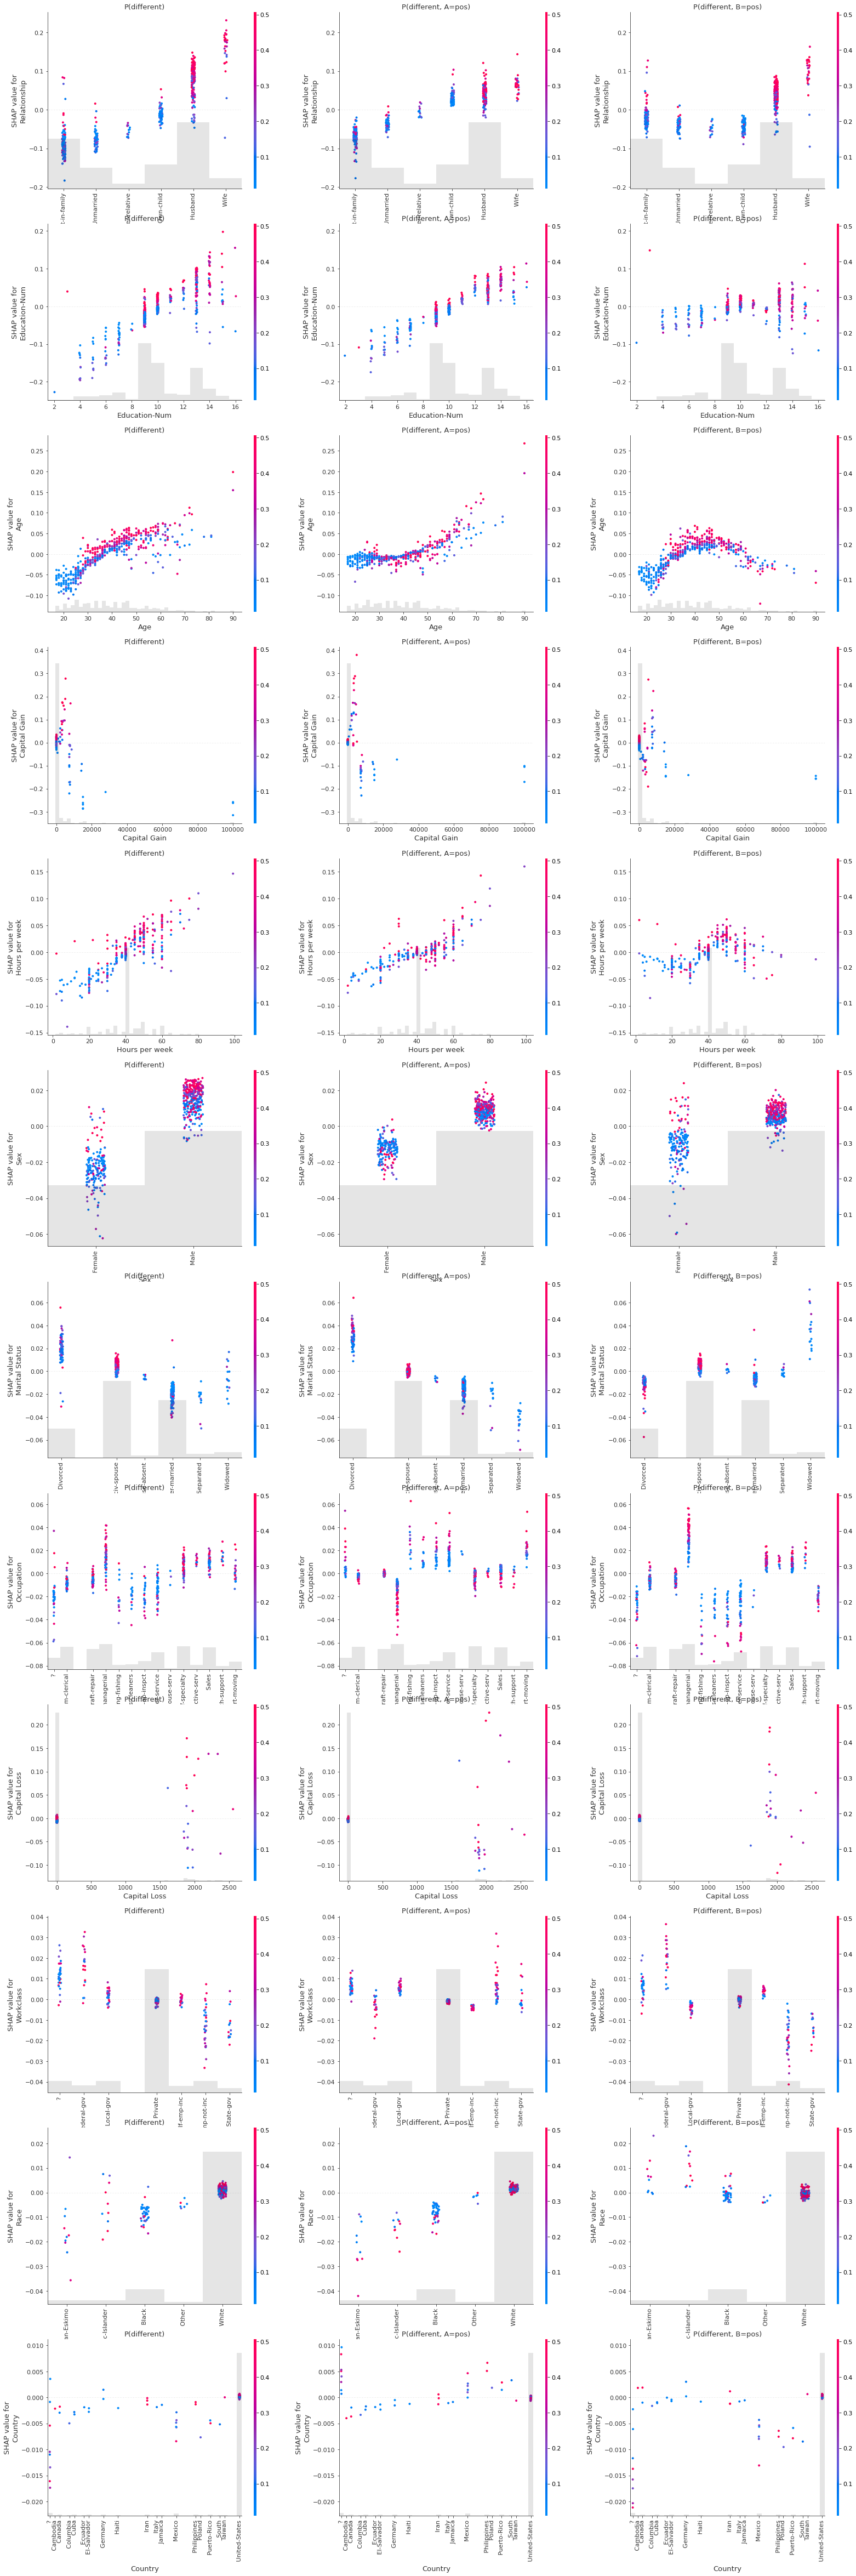

In [12]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2, sharey=ax1)
    shap.plots.scatter(shap_values_diff[:, feature], title='P(different)', ax=ax1, color=proba_diff, show=False)
    shap.plots.scatter(shap_values_diff_a_pos[:, feature], title='P(different, A=pos)', ax=ax2, color=proba_diff, show=False)
    shap.plots.scatter(shap_values_diff_b_pos[:, feature], title='P(different, B=pos)', ax=ax3, color=proba_diff, show=False)
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [13]:
mask = pred_a != pred_b
order = plot.shap_force(shap_values_diff[mask], 'P(different)')
plot.shap_force(shap_values_diff_a_pos[mask], 'P(different, A=pos)', ordering=order)
plot.shap_force(shap_values_diff_b_pos[mask], 'P(different, B=pos)', ordering=order);

In [14]:
idx_pred_eq = resample(indices[pred_a == pred_b], n_samples=100, replace=False, random_state=2)
order = plot.shap_force(shap_values_diff[idx_pred_eq], 'P(different)')
plot.shap_force(shap_values_diff_a_pos[idx_pred_eq], 'P(different, A=pos)', ordering=order)
plot.shap_force(shap_values_diff_b_pos[idx_pred_eq], 'P(different, B=pos)', ordering=order);

### Hierarchically Clustered SHAP Values

In [24]:
idx_diff = indices[pred_a != pred_b]
idx_equal = indices[pred_a == pred_b]
if len(idx_diff) > 500:
    idx_diff = shuffle(idx_diff, random_state=0, n_samples=500)
if len(idx_equal) > 500:
    idx_equal = shuffle(idx_equal, random_state=0, n_samples=500)

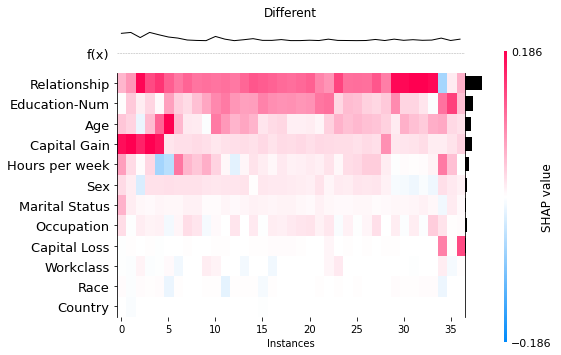

In [25]:
plot.shap_heatmap(shap_values_diff[idx_diff], 'Different', feature_order)

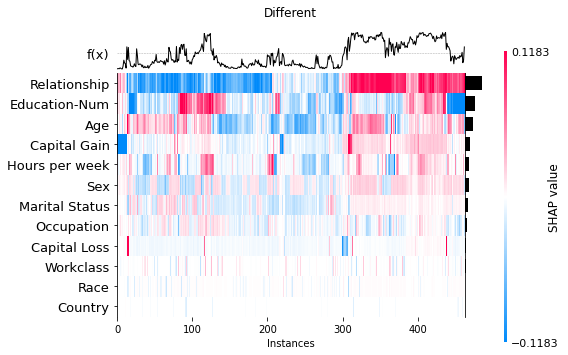

In [26]:
plot.shap_heatmap(shap_values_diff[idx_equal], 'Different', feature_order)

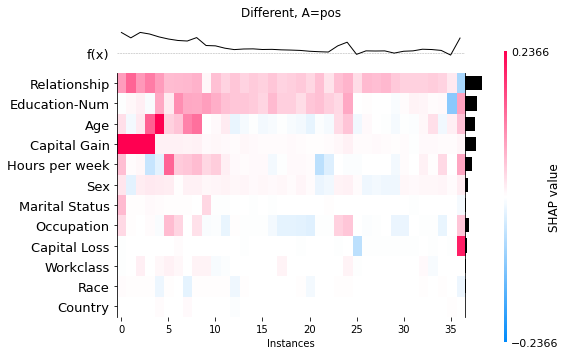

In [27]:
plot.shap_heatmap(shap_values_diff_a_pos[idx_diff], 'Different, A=pos', feature_order)

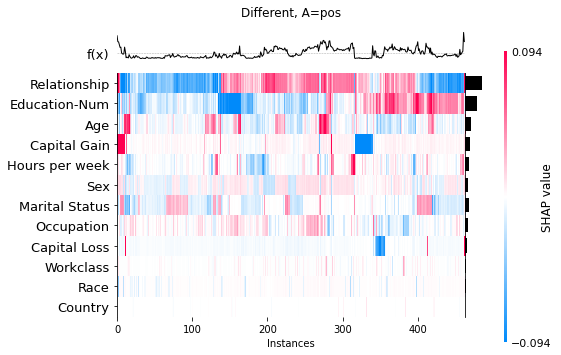

In [28]:
plot.shap_heatmap(shap_values_diff_a_pos[idx_equal], 'Different, A=pos', feature_order)

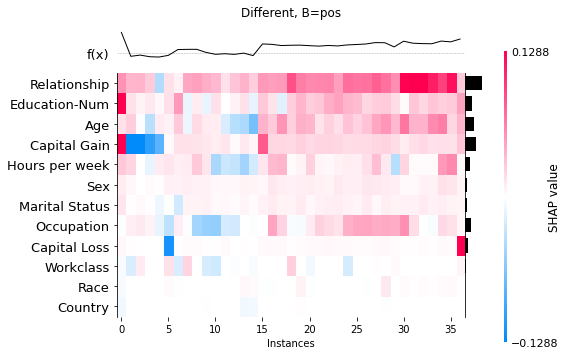

In [29]:
plot.shap_heatmap(shap_values_diff_b_pos[idx_diff], 'Different, B=pos', feature_order)

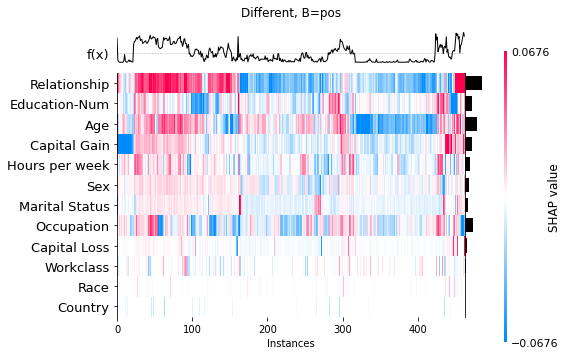

In [30]:
plot.shap_heatmap(shap_values_diff_b_pos[idx_equal], 'Different, B=pos', feature_order)

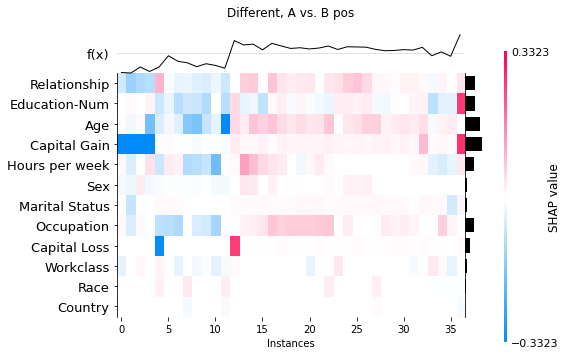

In [31]:
plot.shap_heatmap(shap_values_diff_a_vs_b_pos[idx_diff], 'Different, A vs. B pos', feature_order)

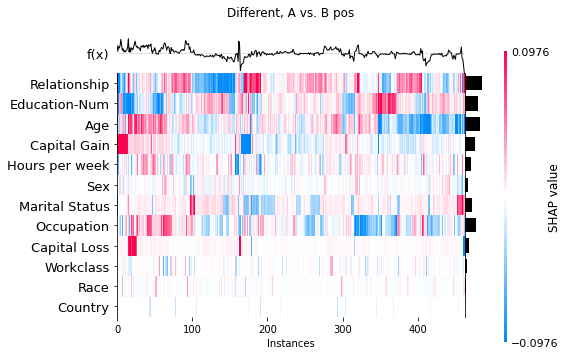

In [32]:
plot.shap_heatmap(shap_values_diff_a_vs_b_pos[idx_equal], 'Different, A vs. B pos', feature_order)